In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import string

%matplotlib inline

#sns.set_style("dark")

In [40]:
def get_hour(item):
    return item.hour

def get_day_frame(directory, date, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    """
    files = glob.glob(directory + '/*.csv') 
    frames = []
    for filename in files:
        obs = pd.read_csv(filename, header=None, names=col_names)
        
        # Remove nan columns
        obs.dropna(thresh=dropna_thres)
        
        # Parse filename to get time of the record
        if parse_filename:
            components = string.split(filename, '_')
            timestr = string.join(components[1:], ':')[:-4]
            starttime = pd.to_datetime(timestr)
            
            cum_time = np.cumsum(obs.Interval)
            cum_time_delta = pd.to_timedelta(cum_time, unit='s')
            obs['Time'] = starttime + cum_time_delta
        
                 
        
        frames.append(obs)

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    if not parse_filename:
        day_frame['Time'] = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Time.apply(get_hour) >= 7) & (day_frame.Time.apply(get_hour) <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
        
    # Remove entries which exceed a cutoff area
    if cutoff_area != None:
        day_frame = day_frame[day_frame.Area < cutoff_area]
        
    
    
    return day_frame
    

In [17]:
day_frame_0925 = get_day_frame('2CW100/0925/', (9, 25, 2016))
day_frame_0926 = get_day_frame('2CW100/0926/', (9, 26, 2016))
day_frame_0927 = get_day_frame('2CW100/0927/', (9, 27, 2016))
day_frame_0928 = get_day_frame('2CW100/0928/', (9, 28, 2016))
day_frame_0929 = get_day_frame('2CW100/0929/', (9, 29, 2016))
day_frame_0930 = get_day_frame('2CW100/0930/', (9, 30, 2016))

frames = [day_frame_0925, day_frame_0926, day_frame_0927, \
          day_frame_0928, day_frame_0929, day_frame_0930]

frame_2CW100_all = pd.concat(frames)


In [41]:
frame_2CW305_all

,Interval,x,y,Area,Hour,Minute,Second,Time,Day,Month,Year,Light
0,0.411790,47.851,55.770,383,NaN,NaN,NaN,2016-07-07 15:03:00.411790,7,7,2016,True
1,0.038248,46.740,55.455,404,NaN,NaN,NaN,2016-07-07 15:03:00.450038,7,7,2016,True
2,0.054550,47.828,55.727,395,NaN,NaN,NaN,2016-07-07 15:03:00.504588,7,7,2016,True
3,0.026689,48.022,55.884,372,NaN,NaN,NaN,2016-07-07 15:03:00.531277,7,7,2016,True
4,0.046363,48.168,55.797,374,NaN,NaN,NaN,2016-07-07 15:03:00.577640,7,7,2016,True
5,0.018067,47.846,55.737,369,NaN,NaN,NaN,2016-07-07 15:03:00.595707,7,7,2016,True
6,0.016440,47.730,55.647,374,NaN,NaN,NaN,2016-07-07 15:03:00.612147,7,7,2016,True
7,0.037181,47.775,55.797,369,NaN,NaN,NaN,2016-07-07 15:03:00.649328,7,7,2016,True
8,0.052121,47.551,55.865,363,NaN,NaN,NaN,2016-07-07 15:03:00.701449,7,7,2016,True
9,0.015030,48.000,55.851,376,NaN,NaN,NaN,2016-07-07 15:03:00.716479,7,7,2016,True


In [39]:
day_frame_0707 = get_day_frame('2CW305/0707/', (7, 7, 2016), parse_filename=True)
day_frame_0708 = get_day_frame('2CW305/0708/', (7, 8, 2016), parse_filename=True)
day_frame_0709 = get_day_frame('2CW305/0709/', (7, 9, 2016), parse_filename=True)
day_frame_0710 = get_day_frame('2CW305/0710/', (7, 10, 2016), parse_filename=True)
day_frame_0711 = get_day_frame('2CW305/0711/', (7, 11, 2016), parse_filename=True)

frames = [day_frame_0707, day_frame_0708, day_frame_0709, \
          day_frame_0710, day_frame_0711]

frame_2CW305_all = pd.concat(frames)



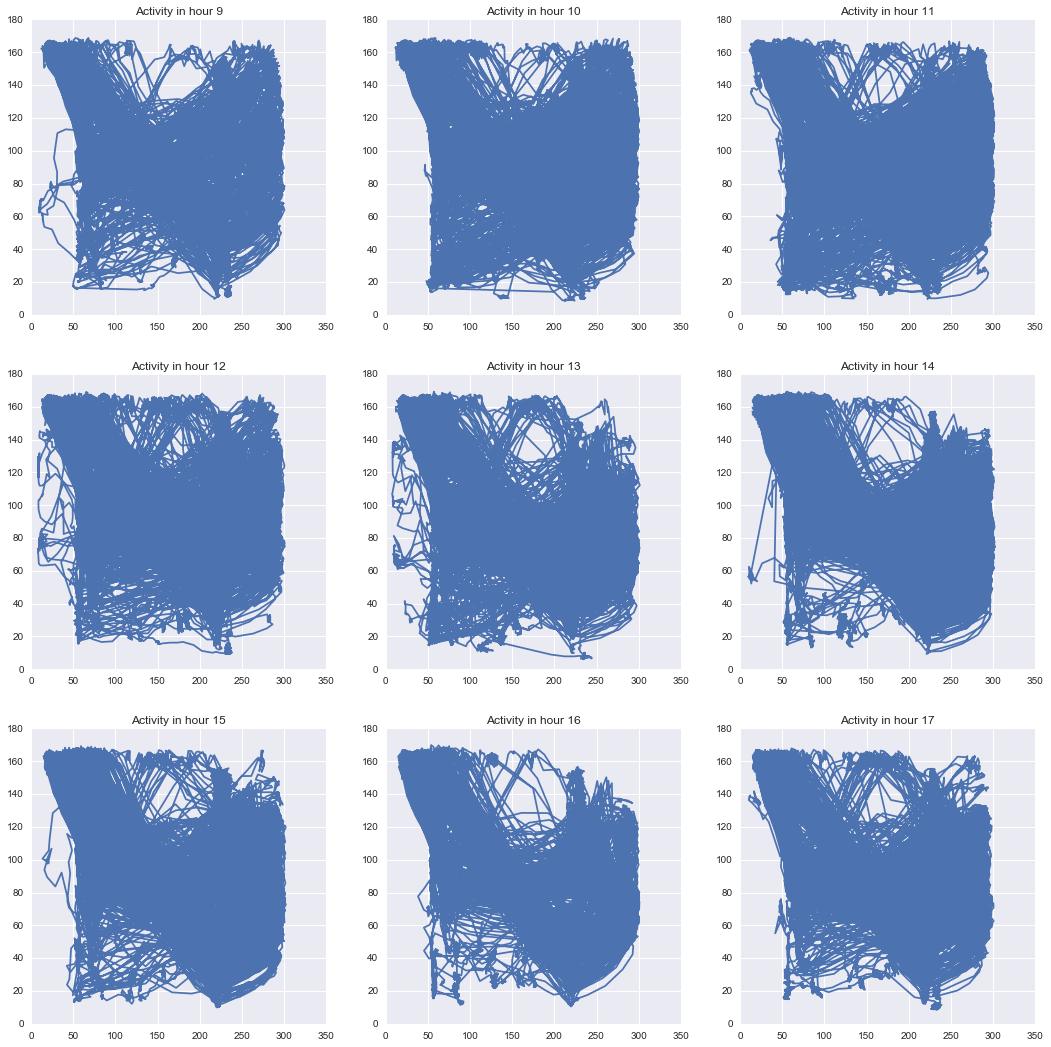

In [4]:
frame_to_display = day_frame_0925

# Visualization of hourly patterns
fig, ax = plt.subplots(3, 3, figsize=(18,18))
ax_pos = [(x,y) for x in range(3) for y in range(3)] # list all positions on the grid

hour = 9
for coord in ax_pos:
    hour_frame = frame_to_display[frame_to_display['Hour'] == hour]
    ax[coord].plot(hour_frame['x'], hour_frame['y'])
    ax[coord].set_title('Activity in hour ' + str(hour))
    
    hour += 1

In [19]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None, use_time_field=False):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = day_frame.Time
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')


In [20]:
# Calculate displacement and zeitbeger time
frame_2CW100_all['Displacement'] = get_displacement(frame_2CW100_all)
frame_2CW100_all['ZeitTime'] = get_zeit(frame_2CW100_all, start_time_str='9/25/2016 7:00AM')




In [42]:
frame_2CW305_all['Displacement'] = get_displacement(frame_2CW305_all)
frame_2CW305_all['ZeitTime'] = get_zeit(frame_2CW305_all, start_time_str='7/7/2016 7:00AM')

In [52]:
ax.get_ylim()

(0.0, 350.0)

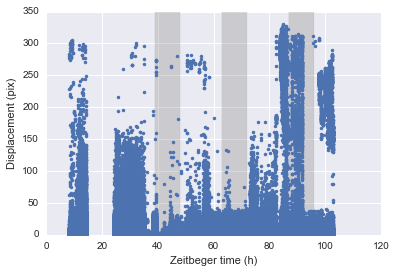

In [53]:
# Make a plot of all displacement values
fig, ax = plt.subplots()
ax.plot(frame_2CW305_all['ZeitTime'], frame_2CW305_all['Displacement'], '.')
ax.fill_between(frame_2CW305_all.ZeitTime, 0, ax.get_ylim()[1], 
                where=~frame_2CW305_all.Light, color='gray',  alpha=0.3)
ax.set_xlabel('Zeitbeger time (h)')
ax.set_ylabel('Displacement (pix)')

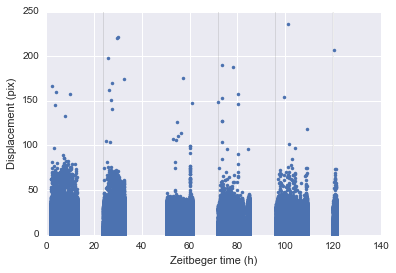

In [21]:
# Make a plot of all displacement values
plt.plot(frame_2CW100_all['ZeitTime'], frame_2CW100_all['Displacement'], '.')
plt.fill_between(frame_2CW100_all.ZeitTime, 0, 250, where=~frame_2CW100_all.Light, color='gray',  alpha=0.3)
plt.xlabel('Zeitbeger time (h)')
plt.ylabel('Displacement (pix)')

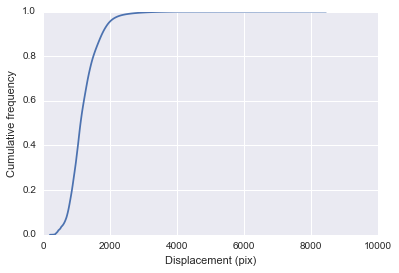

In [8]:
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

# Display the ecdf of all displacements
x, y = ecdf(frame_2CW100_all.Area)
plt.plot(x, y)
plt.xlim((0,10000))
plt.xlabel('Displacement (pix)')
plt.ylabel('Cumulative frequency')

In [22]:
def aggregate_activity(day_frame, time, unit):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame['Displacement'].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum()
    
    # Create data frame with day information
    day = agg_sum_grouped.index / int(SECS_PER_DAY / group_duration)
    time_in_day = agg_sum_grouped.index % int(SECS_PER_DAY / group_duration)
    
    agg_frame_grouped = pd.DataFrame.from_items([('Period', time_in_day), 
                                                 ('Activity', agg_sum_grouped), ('Day', day)])
    
    
    
    return agg_frame_grouped

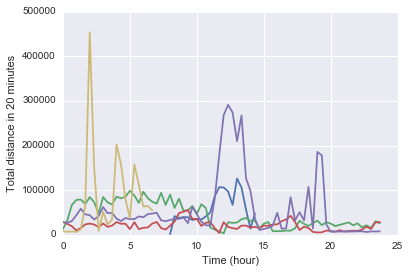

In [47]:
activity = aggregate_activity(frame_2CW305_all, time=20, unit='Minute')
for day in range(5):
    activity_day = activity.Activity[activity.Day == day]
    time_in_day = activity.Period[activity.Day == day] /3
    plt.plot(time_in_day, activity_day)
plt.xlabel('Time (hour)')
plt.ylabel('Total distance in 20 minutes')
